In [1]:
import os
import json
import torch.distributed as dist

os.environ["MASTER_ADDR"] = "127.0.0.1"
os.environ["MASTER_PORT"] = "29500"
os.environ["RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

# Initialize the process group (choose 'nccl' for GPUs, or 'gloo' if using CPU)
dist.init_process_group(backend="nccl", rank=0, world_size=1)

all_captions_file_path = "/radar-imaging-dataset/P2SIF/lidar-radar-clip/caption/caption_embeddings.json"

with open(all_captions_file_path, 'r') as f:
    all_captions = json.load(f)

In [2]:
import torch
from CLIP.clip import clip
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, Lambda
from torchvision.transforms import InterpolationMode, ConvertImageDtype
BICUBIC = InterpolationMode.BICUBIC

model_path_radar = "/radar-imaging-dataset/P2SIF/lidar-radar-clip/models/ViT-L_14_train_radar_epoch4.pth"
model_path_lidar_1 = "/radar-imaging-dataset/P2SIF/lidar-radar-clip/models/ViT-B_32_train_lidar_epoch0.pth"
model_path_lidar_2 = "/radar-imaging-dataset/P2SIF/lidar-radar-clip/models/ViT-B_32_train_lidar_epoch2.pth"

model_name_radar = "/".join(model_path_radar.split("/")[-1].split("_")[0 : 2])
model_name_lidar_1 = "/".join(model_path_lidar_1.split("/")[-1].split("_")[0 : 2])
model_name_lidar_2 = "/".join(model_path_lidar_2.split("/")[-1].split("_")[0 : 2])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_radar = torch.load(model_path_radar, map_location = device)
model_lidar_1 = torch.load(model_path_lidar_1, map_location = device)
model_lidar_2 = torch.load(model_path_lidar_2, map_location = device)

def transform_image_lidar(n_px):
    return Compose([
        Resize(n_px, interpolation=BICUBIC),
        CenterCrop(n_px),
        ConvertImageDtype(torch.float),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])

def transform_image_radar(n_px):
    return Compose([
        Resize(n_px, interpolation=BICUBIC),
        CenterCrop(n_px),
        ConvertImageDtype(torch.float),
        Lambda(lambda x: x.repeat(1, 3, 1, 1)),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])

transform_radar = transform_image_radar(model_radar.module.visual.input_resolution)
transform_lidar_1 = transform_image_lidar(model_lidar_1.module.visual.input_resolution)
transform_lidar_2 = transform_image_lidar(model_lidar_2.module.visual.input_resolution)

In [3]:
from carla_dataset import generate_carla_dataset
from torch.utils.data import DataLoader

data_root = "/radar-imaging-dataset/P2SIF/carla_data/"
num_repetitions = 1
test_size = 0.993
load_only_train = True

train_set, test_set = generate_carla_dataset(
    data_root = data_root, 
    test_size = test_size, 
    num_repetitions = num_repetitions, 
    load_only_train = load_only_train)

train_loader = DataLoader(train_set, batch_size=1, shuffle=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/user/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def get_captions(model, model_name, image_data, transform, all_captions, top_k = 1):
    model.eval()
    with torch.no_grad():
        processed_image = transform(image_data).to(device)
        image_features = model.module.encode_image(processed_image)
        
    gt_embeddings = all_captions[model_name]
    gt_embeddings = torch.tensor(gt_embeddings).to(device)
    gt_embeddings = gt_embeddings.squeeze(1)
    
    # Find closest caption by cosine loss
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    gt_embeddings = gt_embeddings / gt_embeddings.norm(dim=-1, keepdim=True)
    
    similarity = (100.0 * gt_embeddings @ image_features.T).squeeze()

    _, topk = torch.topk(similarity, top_k)
    topk = [t.item() for t in topk]
    
    # extract caption from all_captions["captions"]
    pred_caption = [all_captions["captions"][k] for k in topk]
    return pred_caption

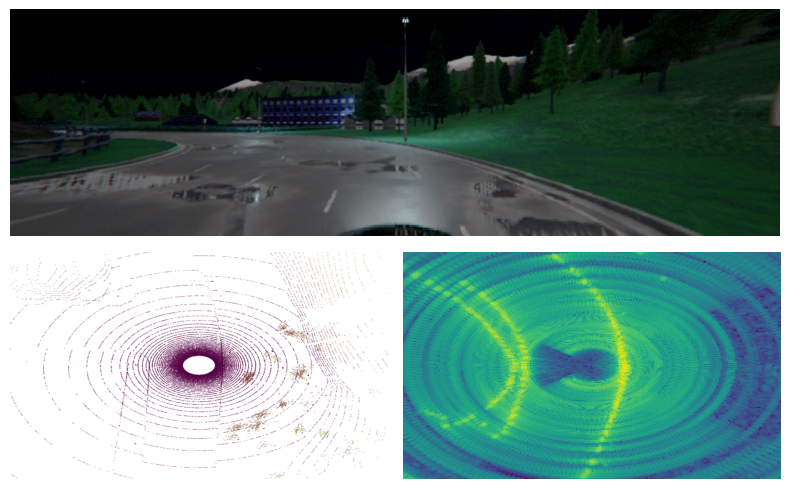

Actual caption: No vehicles nearby

Predicted caption from LiDAR trained for one epoch:
Pred 1: There are six cars and one bike nearby
Pred 2: There are seven cars and two bikes nearby
Pred 3: There are six cars and two bikes nearby

Predicted caption from LiDAR trained for three epoch:
Pred 1: There are five cars and one bike nearby
Pred 2: There are six cars and one bike nearby
Pred 3: There are six cars and two bikes nearby

Predicted caption from Radar trained for five epoch:
Pred 1: There are two cars and no bike nearby
Pred 2: There is one car and no bike nearby
Pred 3: There are two cars and five bikes nearby


In [15]:
import matplotlib.pyplot as plt

dat = next(iter(train_loader))
img = dat["image"][0].numpy().transpose(1, 2, 0)
lidar_bev_img = dat['lidar_bev'][0].numpy().transpose(1, 2, 0)
radar = dat['radar'][0].numpy().transpose(1, 2, 0)
caption = dat['caption'][0]

fig, ax = plt.subplot_mosaic("AA;BC", figsize=(8,5))

ax['A'].imshow(img, aspect='auto')
ax['A'].set_xticks([])
ax['A'].set_yticks([])
ax['A'].set_axis_off()

ax['B'].imshow(lidar_bev_img, aspect='auto')
ax['B'].set_xticks([])
ax['B'].set_yticks([])
ax['B'].set_axis_off()

ax['C'].imshow(radar, aspect='auto')
ax['C'].set_xticks([])
ax['C'].set_yticks([])
ax['C'].set_axis_off()
plt.tight_layout()
plt.show()

print(f"Actual caption: {caption}")

top_k = 3

caption_from_lidar_1 = get_captions(model_lidar_1, model_name_lidar_1, dat['lidar_bev'], transform_lidar_1, all_captions, top_k)
caption_from_lidar_2 = get_captions(model_lidar_2, model_name_lidar_2, dat['lidar_bev'], transform_lidar_2, all_captions, top_k)
caption_from_radar = get_captions(model_radar, model_name_radar, dat['radar'], transform_radar, all_captions, top_k)

print("\nPredicted caption from LiDAR trained for one epoch:")
for i, c in enumerate(caption_from_lidar_1):
    print(f"Pred {i+1}: {c}")

print("\nPredicted caption from LiDAR trained for three epoch:")
for i, c in enumerate(caption_from_lidar_2):
    print(f"Pred {i+1}: {c}")

print("\nPredicted caption from Radar trained for five epoch:")
for i, c in enumerate(caption_from_radar):
    print(f"Pred {i+1}: {c}")